In [1]:
import numpy as np # for numeric calculation
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for visualization
import seaborn as sns # for vizualization
import librosa as lr # to read and manipulate audio-files
from glob import glob # to read the files
import librosa.display
import os
import IPython.display as ipd

source: https://mikesmales.medium.com/sound-classification-using-deep-learning-8bc2aa1990b7

In [2]:
# Set directory for sourcefiles - fan
# audio_files = []
# audio_files_fan = []


data_dir = "./-6_dB_fan/fan/id_00/normal"
audio_files = glob(data_dir + "/*.wav")


data_dir_fan = "./-6_dB_fan/fan/id_00/abnormal"
audio_files_fan = glob(data_dir_fan + "/*.wav")

In [3]:
x = len(audio_files)
y = len(audio_files_fan)
print(x, y)

1011 407


In [4]:
audio_files[1]

'./-6_dB_fan/fan/id_00/normal\\00000001.wav'

In [5]:
plt.figure(figsize = (12, 4))
data, sample_rate = librosa.load(audio_files[0])
ipd.Audio(audio_files[0])

<Figure size 864x288 with 0 Axes>

In [6]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc = 13)
    mfccs_scaled_features = np.mean(mfccs.T, axis = 0)
    return mfccs_scaled_features

In [10]:
extracted_feature = []
for i in range(0, len(audio_files)):
    file_name = audio_files[i]
    class_label = 0 
    data = features_extractor(file_name)
    extracted_feature.append([data, class_label])

In [11]:
for i in range(0, len(audio_files_fan)):
    file_name = (audio_files_fan[i])
    class_label = 1 # for abnormal
    data = features_extractor(file_name)
    extracted_feature.append([data, class_label])

In [15]:
extracted_features_df = pd.DataFrame(extracted_feature, columns= ["Features","Class"])
extracted_features_df.head()

,Features,Class
0,"[-388.7691, 196.16545, -44.832336, 58.219112, ...",0
1,"[-375.57233, 164.52516, -39.330463, 53.67404, ...",0
2,"[-373.74274, 186.59424, -48.768833, 62.632477,...",0
3,"[-372.69772, 163.2637, -40.76904, 54.33696, -4...",0
4,"[-394.7597, 177.50899, -30.31116, 56.75814, -1...",0


In [16]:
X = np.array(extracted_features_df.Features.tolist())

In [17]:
Class = np.array(extracted_features_df.Class.tolist())

In [18]:
# Create the dataframe
df_feature = pd.DataFrame(X)

In [40]:
df_feature.columns = ['0','1','2','3',
                     '4','5','6','7','8','9','10','11','12']

In [41]:
df_class = pd.DataFrame(Class)

In [42]:
df_fan = pd.concat([df_feature, df_class], axis=1)

In [43]:
df_fan.columns = ['0','1','2','3',
                     '4','5','6','7','8','9','10','11','12','class']

In [44]:
df_fan.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,class
0,-388.769104,196.165451,-44.832336,58.219112,-19.365788,28.853043,-9.106186,8.202619,-3.906470,-0.025357,4.554739,-4.086587,5.309733,0
1,-375.572327,164.525162,-39.330463,53.674042,-40.673901,35.346649,-19.527493,31.885033,-4.743448,2.482800,-1.926606,-5.300628,8.632076,0
2,-373.742737,186.594238,-48.768833,62.632477,-24.728729,33.085083,-11.300992,11.494528,-6.223856,1.393281,4.629584,-3.891660,6.065525,0
3,-372.697723,163.263702,-40.769039,54.336960,-41.186550,37.764668,-23.756075,29.189741,-4.479334,-0.182231,-7.015511,-1.629511,10.912957,0
4,-394.759705,177.508987,-30.311159,56.758141,-15.153505,27.438791,-0.201953,13.515721,-0.782874,4.222950,2.678374,-2.002591,8.462102,0


In [45]:
from sklearn.cluster import KMeans

# number of sound clusters
team_size = 2


#audio_metrics
# z-score normalisation
audio_metrics_normalized = (df_feature-df_feature.mean())/df_feature.std()
audio_metrics_normalized = audio_metrics_normalized.rename(columns={'0': '0_zscore',
                                                                        '1':'1_zscore',
                                                                        '2':'2_zscore',
                                                                        '3':'3_zscore',
                                                                       '4':'4_zscore',
                                                                       '5':'5_zscore',
                                                                        '6':'6_zscore',
                                                                       '7':'7_zscore',
                                                                       '8':'8_zscore',
                                                                       '9':'9_zscore',
                                                                       '10':'10_zscore',
                                                                       '11':'11_zscore',
                                                                       '12':'12_zscore'})

# fit a kmeans object to the dataset
kmeans = KMeans(n_clusters=team_size, init='k-means++').fit(audio_metrics_normalized)

# clusters is an attribute of the object
cluster_centers = kmeans.cluster_centers_

# add cluster index to dataframe
cluster_labels = pd.Series(kmeans.labels_, name='cluster')
audio_metrics_normalized = audio_metrics_normalized.join(cluster_labels.to_frame())

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

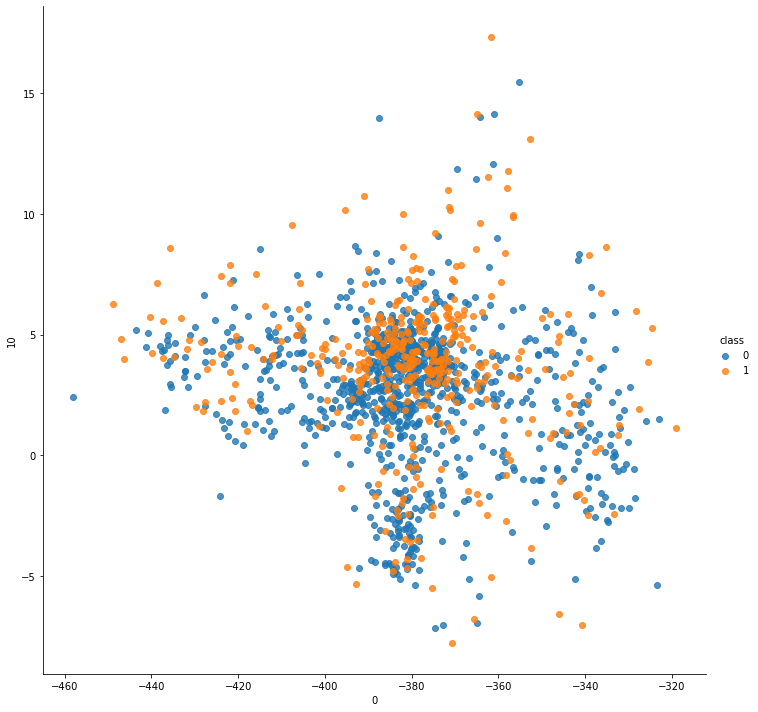

In [47]:
sns.lmplot(x='0', y='10',  height=10, data=df_fan,
           fit_reg=False, hue='class')

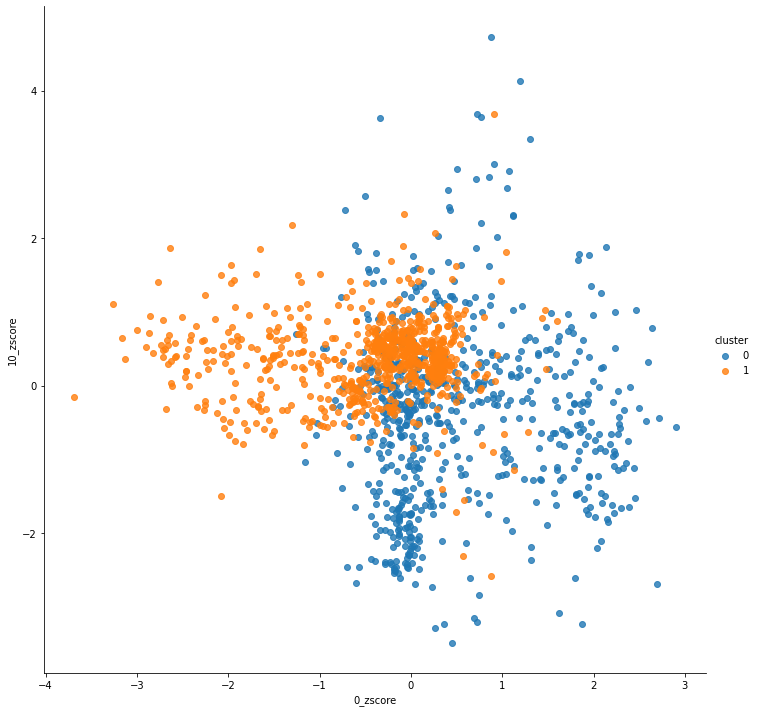

In [48]:
sns.lmplot(x='0_zscore', y='10_zscore',  height=10, data=audio_metrics_normalized,
           fit_reg=False, hue='cluster')

In [49]:
from sklearn import metrics
true_labels = df_fan['class']
pred_labels = audio_metrics_normalized['cluster']
print(metrics.homogeneity_score(true_labels, pred_labels))


print(metrics.completeness_score(true_labels, pred_labels))


#(1 stands for perfectly complete labeling)
print(metrics.v_measure_score(true_labels, pred_labels))

0.0012337594366133786
0.0010702638017080347
0.001146210717896235
